In [7]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [13]:

# Cargar el dataset principal de solicitudes de adelanto en efectivo
cr = pd.read_csv('../project_dataset/extract - cash request - data analyst.csv')
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [14]:
# Crear una copia del DataFrame para preservar el original
credit_requests = cr.copy()

In [15]:
# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fs = pd.read_csv('../project_dataset/extract - fees - data analyst - .csv')
fs.head()


,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [16]:
# Crear una copia del DataFrame para preservar el original
fees = fs.copy()


In [24]:
# Clean `credit_requests`
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cash_request = credit_requests.copy()
#cash_request.fillna({"user_id": cash_request["deleted_account_id"]}, inplace=True)

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']
for col in datetime_columns:
    cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')
    cash_request[col] = cash_request[col].dt.tz_localize(None)

credit_requests['created_at'] = pd.to_datetime(credit_requests['created_at'])
credit_requests['updated_at'] = pd.to_datetime(credit_requests['updated_at'])
credit_requests['reimbursement_date'] = pd.to_datetime(credit_requests['reimbursement_date'])

# Fill missing `user_id` with -1 (or another placeholder)
credit_requests['user_id'] = credit_requests['user_id'].fillna(-1)

# 5. **Limpieza de datos** Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
#cash_request.drop(columns=["deleted_account_id"], inplace=True)
cash_request.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.407830,804.0,2019-12-11 16:47:42.405646,2020-01-09 19:05:21.596363,NaN,NaT,regular,NaT,NaN,NaT,NaT
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054,231.0,2019-12-11 14:24:22.897988,2020-01-09 19:50:12.347780,NaN,NaT,regular,NaT,NaN,NaT,NaT
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773,191.0,2019-12-11 09:46:59.777728,2020-01-09 19:13:35.825041,NaN,NaT,regular,NaT,NaN,NaT,NaT
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163,761.0,2019-12-18 14:26:18.128407,2020-01-09 19:16:10.879606,NaN,NaT,regular,NaT,NaN,NaT,NaT
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.340080,7686.0,2020-05-07 09:21:55.320193,NaT,NaN,NaT,regular,NaT,NaN,NaT,NaT


In [25]:
# 1. Manejo de valores faltantes
# - For simplicity: drop rows where `cash_request_id` is NaN (primary key related)
# - Impute 'category' with 'Unknown', keep `paid_at`, `from_date`, `to_date` for further filtering
data_cleaned = fs.dropna(subset=['cash_request_id'])
data_cleaned['category'] = data_cleaned['category'].fillna('Unknown')

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'paid_at', 'from_date', 'to_date']
for col in datetime_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')

# Standardize column names
data_cleaned.columns = data_cleaned.columns.str.lower().str.replace(' ', '_')

# 3. Filtrado de datos irrelevantes
# Remove rows with invalid or irrelevant `status`
valid_statuses = ['accepted', 'rejected', 'pending']
data_cleaned = data_cleaned[data_cleaned['status'].isin(valid_statuses)]

# Resultado final
display(data_cleaned.info())
data_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16035 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               16035 non-null  int64              
 1   cash_request_id  16035 non-null  float64            
 2   type             16035 non-null  object             
 3   status           16035 non-null  object             
 4   category         16035 non-null  object             
 5   total_amount     16035 non-null  float64            
 6   reason           16035 non-null  object             
 7   created_at       16035 non-null  datetime64[ns, UTC]
 8   updated_at       16035 non-null  datetime64[ns, UTC]
 9   paid_at          15354 non-null  datetime64[ns, UTC]
 10  from_date        2554 non-null   datetime64[ns, UTC]
 11  to_date          2513 non-null   datetime64[ns, UTC]
 12  charge_moment    16035 non-null  object             
dtypes: datetime64[ns, UTC

None

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,Unknown,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00:00,2020-12-17 14:50:07.470110+00:00,NaT,NaT,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00:00,2020-12-08 17:13:10.459080+00:00,NaT,NaT,after
2,16296,23371.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00:00,2020-11-04 19:34:37.432910+00:00,NaT,NaT,after
3,20775,26772.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00:00,2020-11-19 05:09:22.500223+00:00,NaT,NaT,after
4,11242,19350.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00:00,2020-11-02 14:45:20.355598+00:00,NaT,NaT,after


In [26]:
# Merge on `id` and `cash_request_id`
merged_data = pd.merge(
    credit_requests,
    fees,
    left_on='id',
    right_on='cash_request_id',
    how='inner'
)

print(merged_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id_x                        21057 non-null  int64              
 1   amount                      21057 non-null  float64            
 2   status_x                    21057 non-null  object             
 3   created_at_x                21057 non-null  datetime64[ns]     
 4   updated_at_x                21057 non-null  datetime64[ns]     
 5   user_id                     21057 non-null  float64            
 6   moderated_at                11115 non-null  datetime64[ns]     
 7   reimbursement_date          2291 non-null   datetime64[ns]     
 8   cash_request_received_date  19763 non-null  object             
 9   money_back_date             14758 non-null  datetime64[ns]     
 10  transfer_type               21057 non-null  object        

In [27]:
# Average requested amount and fee
print(merged_data['amount'].mean())
print(merged_data['total_amount'].mean())

# Correlation between credit amount and fees
print(merged_data[['amount', 'total_amount']].corr())


81.83354703898941
5.0002374507289735
                amount  total_amount
amount        1.000000     -0.008142
total_amount -0.008142      1.000000


In [28]:
# Total fees by type
fees_by_type = merged_data.groupby('type')['total_amount'].sum()
print(fees_by_type)

# Average fee-to-credit ratio
merged_data['fee_to_credit_ratio'] = merged_data['total_amount'] / merged_data['amount']
avg_ratio = merged_data['fee_to_credit_ratio'].mean()
print(f"Average Fee-to-Credit Ratio: {avg_ratio:.2%}")


type
incident           10980.0
instant_payment    55480.0
postpone           38830.0
Name: total_amount, dtype: float64
Average Fee-to-Credit Ratio: 7.61%


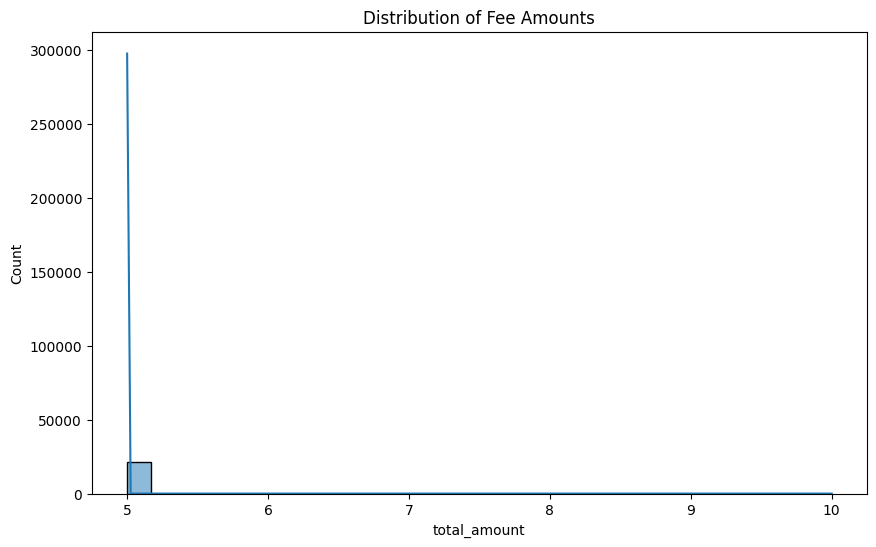

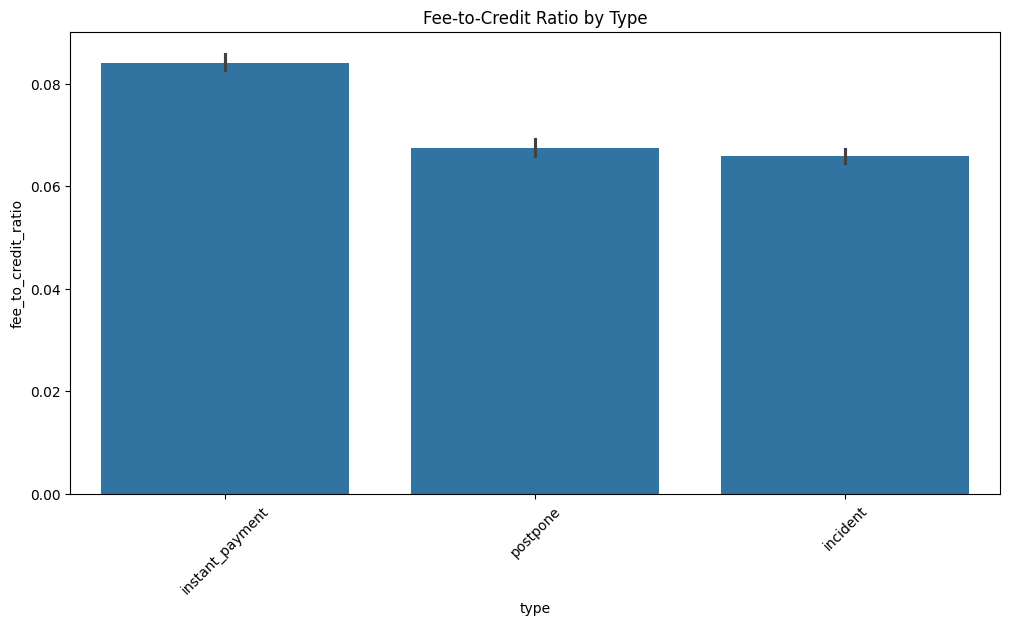

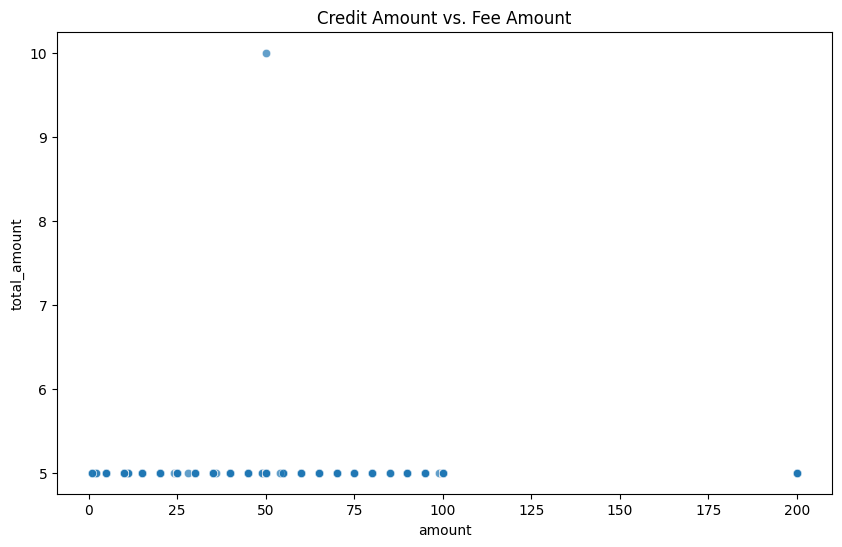

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Fee Amounts
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['total_amount'], bins=30, kde=True)
plt.title('Distribution of Fee Amounts')
plt.show()

# Fee-to-Credit Ratio by Type
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='fee_to_credit_ratio', data=merged_data)
plt.title('Fee-to-Credit Ratio by Type')
plt.xticks(rotation=45)
plt.show()

# Credit Amount vs. Fee Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amount', y='total_amount', data=merged_data, alpha=0.7)
plt.title('Credit Amount vs. Fee Amount')
plt.show()


In [36]:
# verify all credit requests have fees

# Perform a left join to ensure all credit requests are included
merged_data2 = pd.merge(
    credit_requests,
    fees,
    left_on='id',
    right_on='cash_request_id',
    how='left'
)
merged_data2.info()
# Check for credit requests without fees
no_fees = merged_data2[merged_data2['total_amount'].isna()]

# Display the result
if no_fees.empty:
    print("All credit requests have fees associated with them.")
else:
    print(f"There are {len(no_fees)} credit requests without fees.")
    print(no_fees[['id_x', 'amount', 'status_x']])  # Display relevant columns for inspection

# Check statuses of credit requests without fees
print(no_fees['status_x'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id_x                        32094 non-null  int64              
 1   amount                      32094 non-null  float64            
 2   status_x                    32094 non-null  object             
 3   created_at_x                32094 non-null  datetime64[ns]     
 4   updated_at_x                32094 non-null  datetime64[ns]     
 5   user_id                     32094 non-null  float64            
 6   moderated_at                21530 non-null  datetime64[ns]     
 7   reimbursement_date          4061 non-null   datetime64[ns]     
 8   cash_request_received_date  24149 non-null  object             
 9   money_back_date             17204 non-null  datetime64[ns]     
 10  transfer_type               32094 non-null  object        

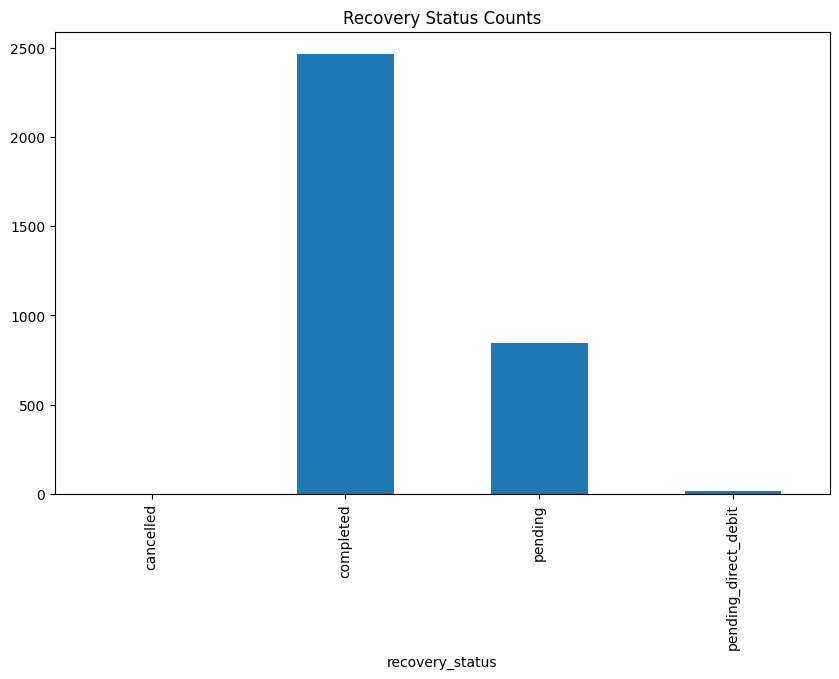

In [37]:
recovery_rates = credit_requests.groupby('recovery_status').size()
recovery_rates.plot(kind='bar', figsize=(10, 6), title='Recovery Status Counts')
plt.show()


In [38]:
missing_by_status = credit_requests.groupby('status').apply(lambda x: x.isnull().sum())
print(missing_by_status)


                       id  amount  status  created_at  updated_at  user_id  \
status                                                                       
active                  0       0       0           0           0        0   
canceled                0       0       0           0           0        0   
direct_debit_rejected   0       0       0           0           0        0   
direct_debit_sent       0       0       0           0           0        0   
money_back              0       0       0           0           0        0   
rejected                0       0       0           0           0        0   
transaction_declined    0       0       0           0           0        0   

                       moderated_at  reimbursement_date  \
status                                                    
active                           37                  58   
canceled                         33                  28   
direct_debit_rejected           377                 748   
di